## Notebook for inferrering message-update parameters G, latent state connectivity matrix J, and observation connectivity matrix V from latent probabilities x

In [2]:
%pylab inline
import sys, importlib
sys.path.append('../code')
from notebookutils import *
from utils import *
# Also import modules using aliases so I can reload them when I make an edit
import notebookutils as ntutils
import tapdynamics as tap
import particlefilter as pfil
importlib.reload(ntutils)
importlib.reload(tap)
importlib.reload(pfil)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<module 'particlefilter' from '/its/home/cg610/coarse_graining_algorithms/coarse_graining_algorithms/notebooks/../code/particlefilter.py'>

## 1. Initialize parameters to true values

In [3]:
# set noise seed
noise_seed = 2022
np.random.seed(noise_seed)
torch.manual_seed(noise_seed)
print('noise_seed = %d' %(noise_seed))


# Ns = no. of latent variables, Ny = no. of inputs
Ns, Nr, Ny = 10,2,10

# process and observation noise covariance matrices
q_process, q_obs = 0, 0
Q_process, Q_obs = q_process*np.eye(Ns), q_obs*np.eye(Nr)    

# filter used for smoothing the input signals
# Carter changed from signal.hamming to signal.windows.hamming 
smoothing_filter = signal.windows.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)


# ground truth TAP model parameters
# lam controls how much new messages update activation
# lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics
lam = np.array([1])  # low pass filtering constant for the TAP dynamics
# This should give us J*x_i*x_j
# The values of G are the coefficients G in the expression G_abc*J^a*x_i^b*x_j^c, where the index corresponds to
# the exponent of J, x_i, and x_j. I believe the order is 100, 101, 102, 110, 111... so the element at index 1 (101) means
# that a and c have exponent 1. In other words, message to Xi only depends on J*Xj
G   = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation

# Connectivity matrix between state nodes
# Ns x Ns
self_coupling_on, sparsity_J, gain_J, Jtype  = 0, 0.5, 3, 'nonferr' # interaction matrix settings
J = gain_J*Create_J(Ns, sparsity_J, Jtype, self_coupling_on)
#J = array([[0,.8,-.4],[.8,0,.2],[-.4,.2,0]])  # No state dependence

# Connectivity matrix between state and observation nodes
# Ns x Ny
if Ns <= Ny:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]
# V = array([[-1,1,1],[1,-1,-1],[1,1,-1]])*3.5
#V = np.zeros((Ns,Ny))  # No input dependence
# Empty embedding matrix because we don't care about neural response

embedding_arr = (Nr,Ns)
U = np.zeros(embedding_arr)
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])

params = {'Ns':Ns,'Ny':Ny,'Nr':Nr,'Q_process':Q_process,'Q_obs':Q_obs,'nltype':'sigmoid','gain_y':25/np.sqrt(Ns),'smoothing_filter':smoothing_filter,'self_coupling_on':self_coupling_on,'sparsity_J':sparsity_J,'Jtype':Jtype  }

noise_seed = 2022


## 2. Run algorithm to get latent probabilities

In [12]:
B_train = 500       # No. of batches; I changed from 25k to 2.5k for training batches. 
                                 # It's also kind of confusing because a single batch is Ns x T 
                                 # instead of multiple Ns x T
                                 # 
T = 30                         # No. of time steps 
kernel  = 30                     # Sliding window
stride = 5                       # how big each jump is
                                 # Here we have consistent input for the entire time period

##################
# These parameters are not used since observations are binary                                 
T_low, T_high = T, T+1           # range of time periods for which input is held constant: T and T+1 means constant for entire period
T_low, T_high = 2, 5          # range of time periods for which input is held constant
yG_low, yG_high = np.sqrt(Ns), np.sqrt(Ns)   # These input gains give us binary observations
yG_low, yG_high = 5, 10   # 


##################
# Specify sampling or message passing function
# runTAP - message passing
# runTAPSampling - sampling
TAP_func=runTAP
y_train, x_train, r_train = tap.generate_TAPdynamics(theta, params, B_train, T, T_low, T_high, yG_low, yG_high,kernel,stride,TAP_func=TAP_func)


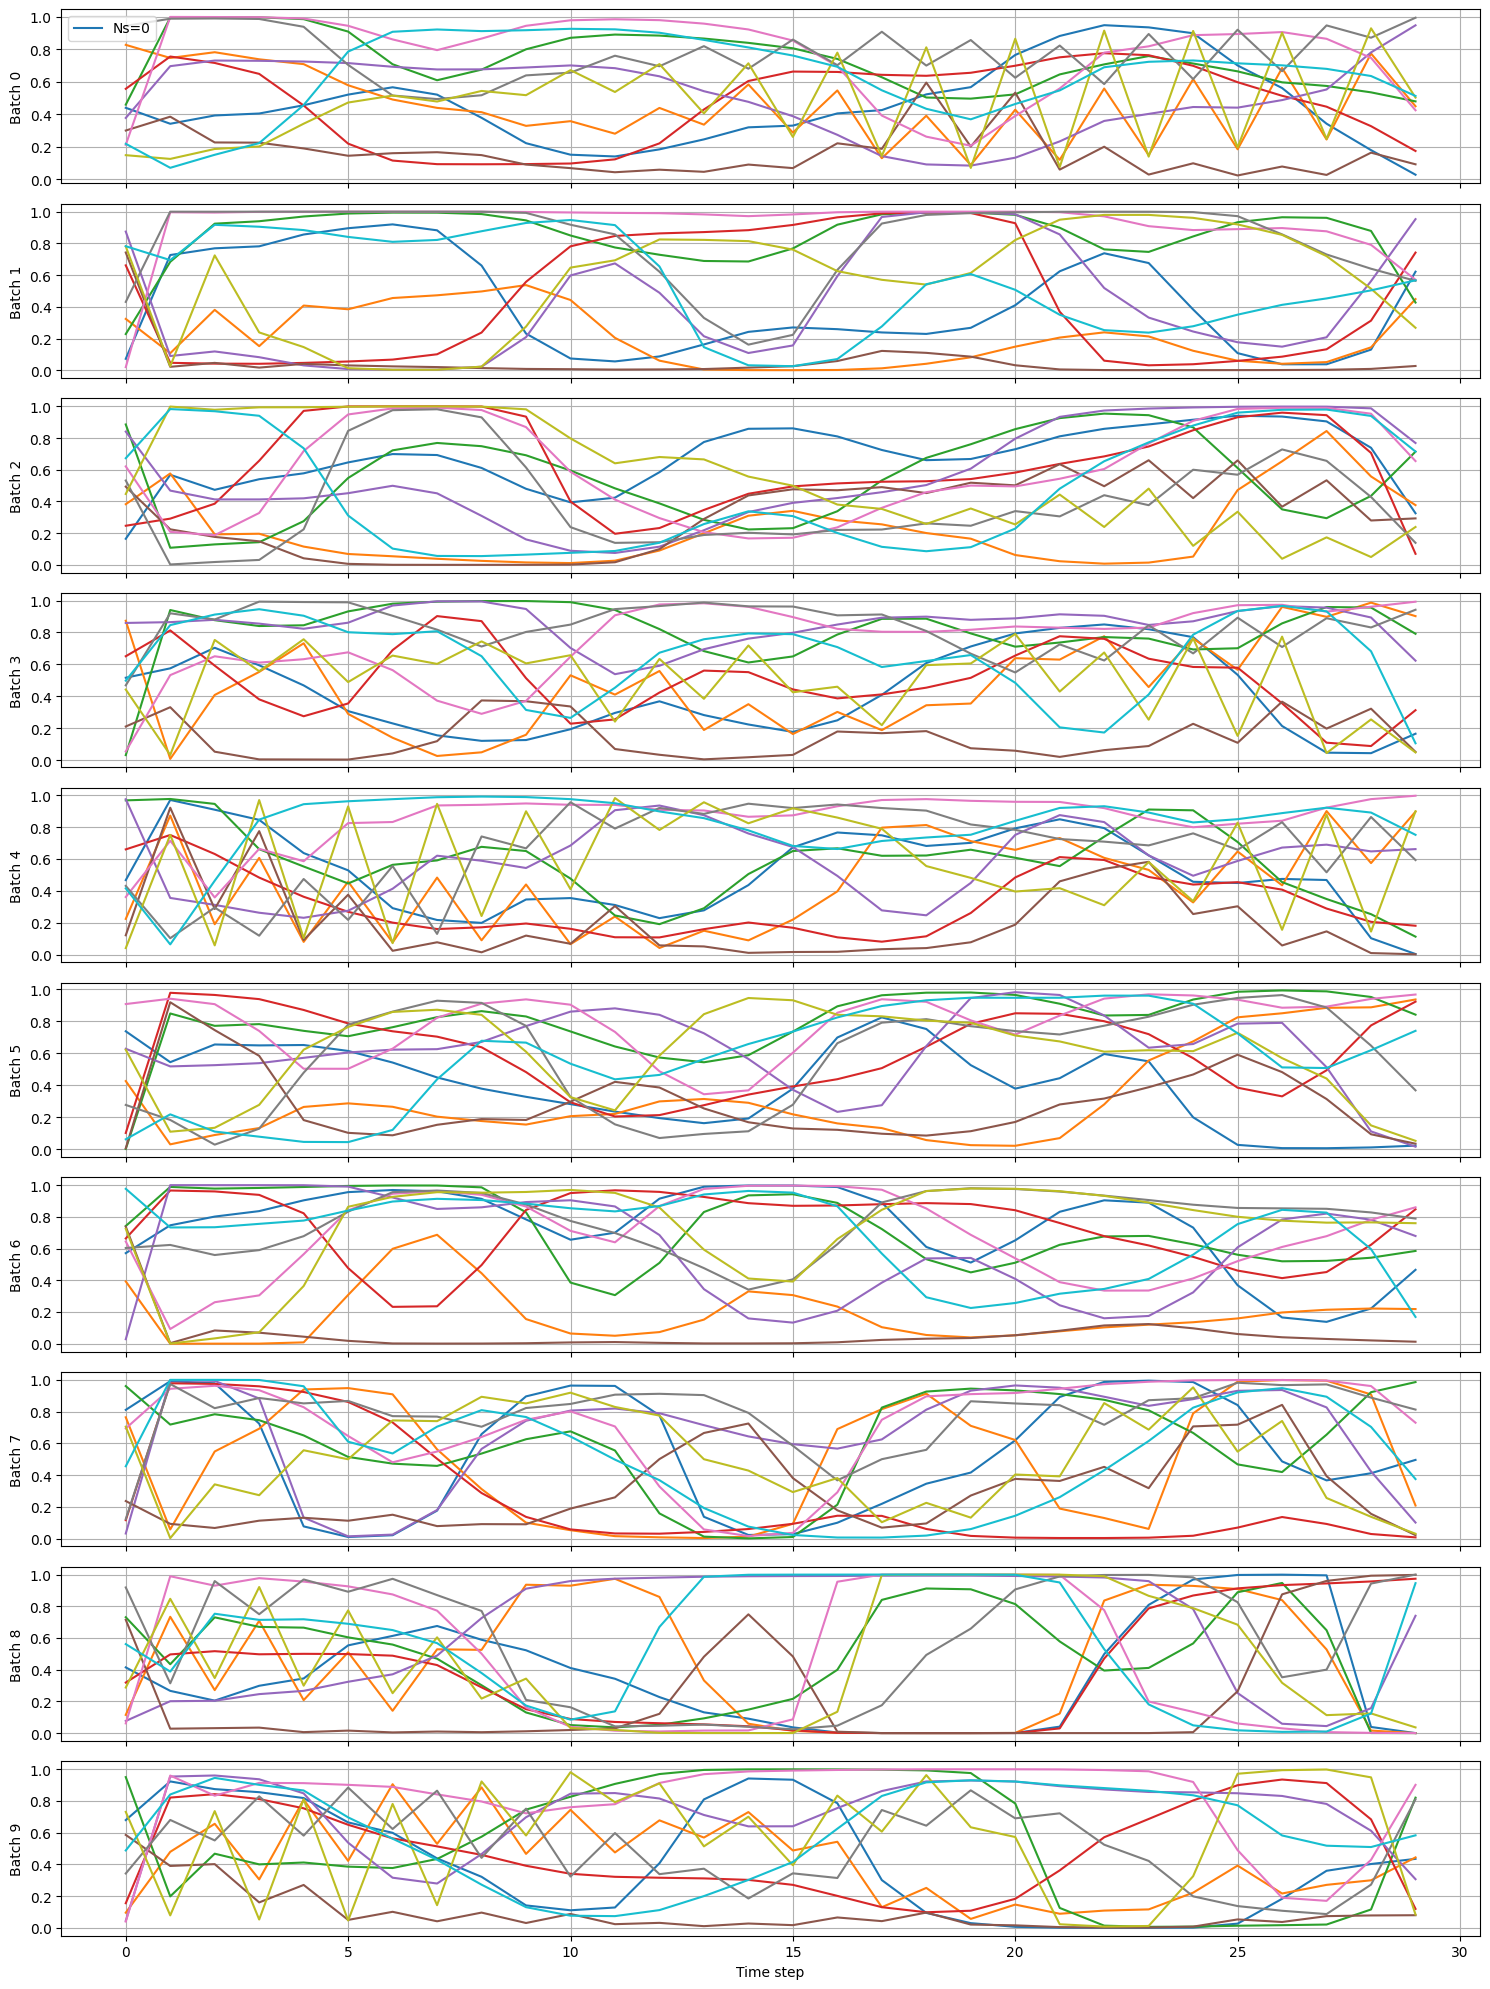

In [13]:
# Plot the first 10 batches of training data
B_to_plot = 10  # first 10 batches
B_total, Ns, T = x_train.shape

fig, axs = plt.subplots(B_to_plot, 1, figsize=(15, 2*B_to_plot), sharex=True)

for b in range(B_to_plot):
    for n in range(Ns):
        axs[b].plot(x_train[b, n, :], label=f'Ns={n}' if n==0 else None)
    axs[b].set_ylabel(f'Batch {b}')
    axs[b].grid(True)

axs[-1].set_xlabel('Time step')
axs[0].legend()  # show legend only on first batch
plt.tight_layout()
plt.show()


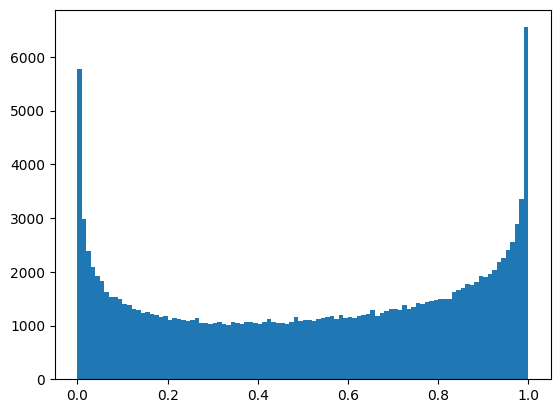

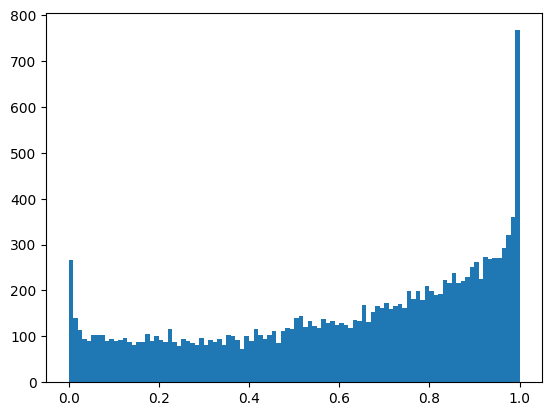

In [14]:
# Plot distribution over latents
plt.hist(x_train.flatten(),100)
plt.show()

# Plot last time step of latents
plt.hist(x_train[:,-1,:].flatten(),100)
plt.show()

### 2.2. Initialize the rest of the parameters

In [15]:
# G_init    = np.random.randn(18)
# G_init[0], G_init[8], G_init[9], G_init[17] = 0, 0, 0, 0
G_init = np.zeros(18)
U_init = U

J_init    = 0.1*Create_J(Ns, 0, params['Jtype'], params['self_coupling_on'])  # create a fully connected initial J with small initial values
# J_init = J

if Ns <= Ny:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2]
else:
    V_init = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[0]
# V_init = V

# Convert data to torch tensors

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

B = B_train

# Q_process_ = torch.tensor(Q_process,device=device,dtype=dtype)
# Q_obs_     = torch.tensor(Q_obs,device=device,dtype=dtype)

# P_process_ = Q_process_.inverse()
# P_obs_     = Q_obs_.inverse()

# r_brain_   = torch.tensor(r_brain,device=device,dtype=dtype)
y_         = torch.tensor(y_train,device=device,dtype=dtype)
latents_   = torch.tensor(x_train,device=device,dtype=dtype)

G_      = torch.tensor(G,device=device,dtype=dtype,requires_grad=False)
J_      = torch.tensor(J,device=device,dtype=dtype,requires_grad=False)
U_      = torch.tensor(U,device=device,dtype=dtype,requires_grad=False)
V_      = torch.tensor(V,device=device,dtype=dtype,requires_grad=False)

# Test to make sure correct params have no loss
# G_init = G.copy()
# U_init = U.copy()
# J_init = J.copy()
# V_init = V.copy()


G_hat_  = torch.tensor(G_init,device=device,dtype=dtype,requires_grad=True)
U_hat_  = torch.tensor(U_init,device=device,dtype=dtype,requires_grad=True)
V_hat_  = torch.tensor(V_init,device=device,dtype=dtype,requires_grad=True)
J_hat_vec_ = torch.tensor(JMatToVec_symm_noself(J_init),device=device,dtype=dtype,requires_grad=True)
# b_hat_ = torch.tensor(b_init,device=device,dtype=dtype,requires_grad=True) if model_type else 0

## 4. Run EM

In [17]:
lrate = 2e-3
lrate = 1e-2
NIterations = 80000
betas = betas=(0.8,0.999) #(0.9, 0.999)


opt_params = [G_hat_, J_hat_vec_, V_hat_]  # parameters to optimize over

optimizer = torch.optim.Adam(opt_params, lr=lrate, betas=betas)

batch_size = 4

LLVec = []  # record the log likelihoods
lossVec = []  # record the losses

t_st = time.time()

# Track best parameters and loss
best_loss = float('inf')
best_params = [p.detach().clone() for p in opt_params]


for iteration in range(NIterations):
    
    if iteration == NIterations//2:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/2, betas=(0.9, 0.999))

    if iteration == 3*NIterations//4:
        optimizer  = torch.optim.Adam(opt_params,lr=lrate/4, betas=(0.9, 0.999))
        
    #zero-gradients at the start of each epoch
    optimizer.zero_grad() 
    
    # select indices of batches
    idx = np.random.randint(low=0,high=B,size=batch_size)
    
    # run particle filter to get posterior for E-step
    # with torch.no_grad():
    #     LL_b_, x_b_, P_b_, W_b_ = particlefilter(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[idx]-b_hat_, y_[idx], P_process_, P_obs_, Np)

        
    # E-step to compute Q(theta,theta_n)
    C_ = pfil.QfunctionSimple(G_hat_, JVecToMat_symm_noself_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), y_[idx,:,:], latents_[idx,:,:])
    
    # M-step
    C_.backward() 
    G_hat_.grad[0], G_hat_.grad[9]  = 0, 0 # set gradient of G0 and G9 to zero
    optimizer.step()
    1
    # Compute and record log likelihood on the test data
    # if (iteration+1)%100 == 0:
    #     with torch.no_grad():
    #         LL_rec_ = particlefilter(G_hat_, JVecToMat_torch(J_hat_vec_,Ns), U_hat_, V_hat_, lam.item(), r_brain_[B:B+10]-b_hat_, y_[B:B+10], P_process_, P_obs_, Np)[0]
    #         LLVec.append(LL_rec_.mean())
    
    # Track best parameters
    if C_.item() < best_loss:
        best_loss = C_.item()
        best_params = [p.detach().clone() for p in opt_params]


    if (iteration+1)%200 == 0:
        # print(f"[{iteration+1}] time elapsed = {(time.time() - t_st)/60:.1f} mins , log likelihood = {LL_rec_.mean():.1f} ")
        # print('[%d] time elapsed = %.1f, log likelihood: %.1f' %(iteration + 1, (time.time() - t_st)/60, LL_rec_.mean()))
        G_np = G_hat_.detach().cpu().numpy()
        J_vec_np = J_hat_vec_.detach().cpu().numpy()
        V_np = V_hat_.detach().cpu().numpy()

        print('[%d] time elapsed = %.1f, loss: %.4f' %
            (iteration + 1, (time.time() - t_st)/60, C_))

        print("    G:", G_np)
        # print("    J_vec:", J_vec_np)
        # print("    V:", V_np)
        lossVec.append(C_.item())
        
print("Finished training.")
G_best = best_params[0]
J_vec_best = best_params[1]
V_best = best_params[2]
print("Best loss: %.4f" % (best_loss))
print("Best parameters obtained:")
print("G:", G_best.cpu().numpy())
print("J_vec:", J_vec_best.cpu().numpy())
print("V:", V_best.cpu().numpy())


[200] time elapsed = 0.2, loss: 16.9424
    G: [ 0.         -0.90429777 -0.87403385 -0.10365566 -0.16795722 -0.02232794
  0.02405551 -0.02585309  0.08033155  0.          0.15874195  0.04121267
 -0.12679227 -0.34850682  0.18090634 -0.33526881 -0.42890865  0.19279724]
[400] time elapsed = 0.4, loss: 12.4654
    G: [ 0.         -0.90824386 -0.60116932 -0.11267636 -0.17975445  0.29182231
  0.14968155 -0.18694321  0.08632128  0.          0.48440103 -0.24107503
  0.01358579 -0.86514357  0.34802388 -0.21256073 -0.68893346  1.01287687]
[600] time elapsed = 0.6, loss: 8.0700
    G: [ 0.         -0.79570728 -0.39204179 -0.15502085 -0.15589989  0.4299375
  0.20567838 -0.26898827  0.02190251  0.          0.70624559 -0.54507965
  0.07353523 -1.01681348  0.45141023 -0.12458757 -0.82203824  1.33667763]
[800] time elapsed = 0.8, loss: 6.3124
    G: [ 0.         -0.7909991  -0.31512169 -0.15609545 -0.14197618  0.4489256
  0.20786838 -0.25113539 -0.00586475  0.          0.7544389  -0.65108987
  0.051249

In [ ]:
Finished training.
Best loss: 0.4130
Best parameters obtained:
G: [ 0.00000000e+00 -1.01255739e+00 -3.55301362e-03  2.05306744e-03
 -1.34321259e-02  1.42403634e-02 -1.38608061e-03  1.29756057e-02
 -1.35364639e-02  0.00000000e+00  1.03045821e+00 -1.02986726e+00
 -6.59745051e-04 -2.05633103e+00  2.05678002e+00  9.16303828e-04
 -4.56158619e-03  5.68672794e-03]
J_vec: [ 4.85168884e-01 -3.06177727e-01  4.28830279e-02 -2.65813676e-04
 -3.03097427e-04 -4.01579679e-04 -5.40233934e-04  4.06319926e-06
  6.56289319e-04  2.96336530e-04 -5.39111370e-04  1.49143174e-03
  4.52587761e-01  9.48563661e-04 -5.92888045e-01  1.85827707e+00
 -1.31886545e-03  2.69227267e-01 -1.11576463e-03  1.03068189e-04
 -1.35153099e+00 -4.55785978e-04 -3.31019468e-05  9.44394518e-02
  4.52549818e-04  1.35183531e-04 -2.07892775e-05 -4.33148201e-04
  7.30012948e-06  5.65033695e-04 -2.32319231e-04 -1.99218750e-01
 -3.07043185e-01 -6.34127886e-04  2.04253314e-05  8.15342636e-01
  1.32112618e+00  1.92356491e+00  5.15470809e-01 -4.90749334e-01
 -2.43440297e-01 -1.23750834e+00 -1.75885495e+00  1.72352529e-04
 -6.80651051e-05]
V: [[ 0.02865079 -0.43816326  0.24538047 -0.47056094 -0.5057233  -0.03093158
  -0.12728502  0.02209391 -0.08672569 -0.49470654]
 [-0.18002217  0.34439028  0.37407751 -0.15029486 -0.23478003  0.10954613
   0.36134635  0.52190883 -0.39443554  0.24600099]
 [-0.07347914  0.1606651  -0.27039237  0.00636329 -0.69889515 -0.22880154
  -0.19819247 -0.28711471  0.00504345  0.48157233]
 [ 0.60495933  0.59425934  0.30477308 -0.19848512 -0.01343437  0.04202385
  -0.0328211  -0.34861952  0.03840325 -0.15464492]
 [ 0.01686643 -0.39291765  0.39721778  0.17351016  0.00155662  0.0413172
   0.50446923 -0.56212679 -0.15595825  0.25011184]
 [-0.06973064 -0.14829605  0.37904537 -0.46157076  0.23013893  0.04793712
  -0.30854432  0.06443547  0.43785641  0.52061215]
 [ 0.21930845 -0.07553467  0.40996165  0.58487929 -0.24051044 -0.31507356
  -0.05259986  0.32618341  0.40803084 -0.04936494]
 [ 0.28075246 -0.16063113  0.04226698 -0.05667397  0.26954126 -0.63910063
  -0.25277006  0.08790162 -0.55845856  0.16114702]
 [ 0.53664547 -0.29009775 -0.12397749  0.16857763 -0.11639631  0.60628084
  -0.223151    0.19992451 -0.21943712  0.25317232]
 [-0.41455528  0.1427157   0.38430758  0.31547894  0.03140216  0.23156281
  -0.58984554 -0.22253907 -0.30630404 -0.11574229]]

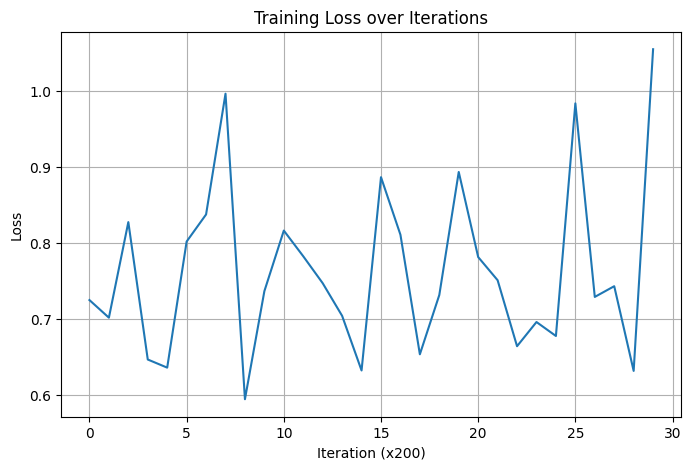

In [18]:
# Plot the loss over last 30 iterations
plt.figure(figsize=(8, 5))
plt.plot(lossVec[-30:])
plt.xlabel('Iteration (x200)')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.grid(True)
plt.show()

# G_hat_ = G_best
# J_hat_vec_ = J_best_vec
# V_hat_ = V_best

## 6. Visualizing results

In [19]:
def reshapeG(GVec):
    GVec = GVec.tolist()
    GVec.pop(9)
    GVec.pop(0)
    return np.array(GVec)

def offdiagonal(J):
    J_temp = J.copy()
    M = J.shape[0]
    for i in range(M):
        J_temp[i,i] = np.nan
    return J_temp

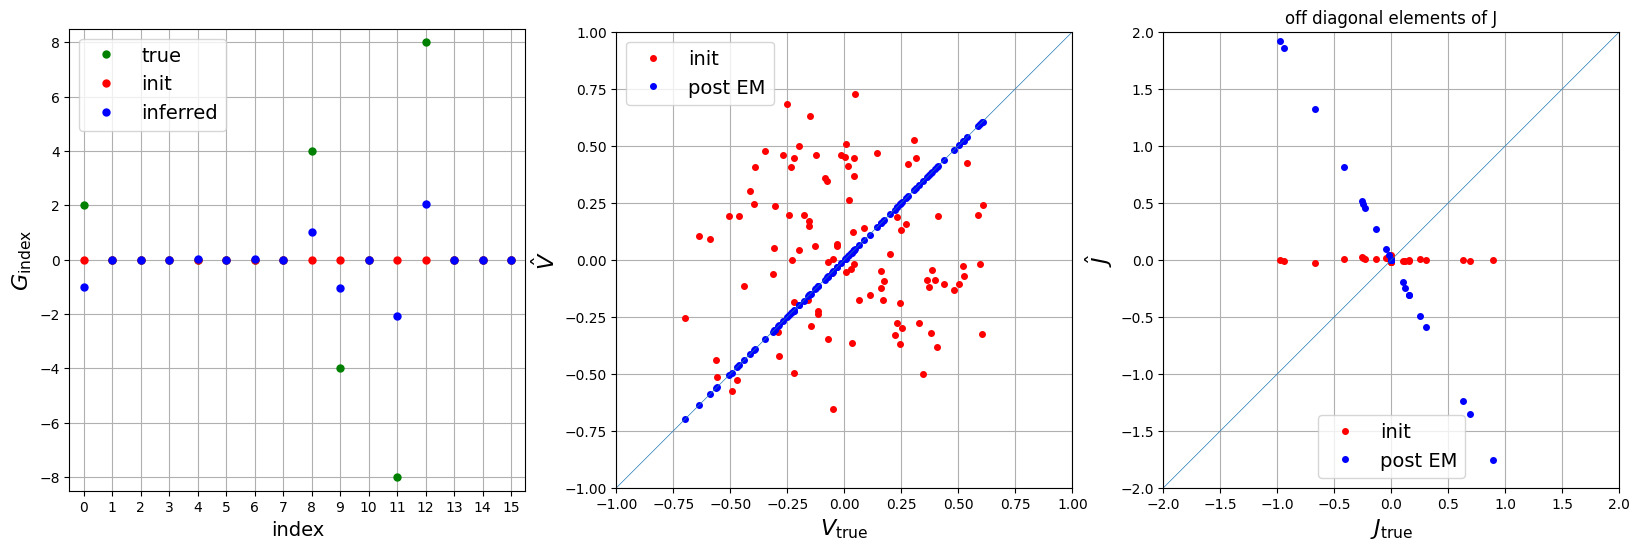

hi


In [20]:
G_hat = G_best.detach().cpu().numpy()
V_hat = V_best.detach().cpu().numpy()
J_hat = JVecToMat_symm_noself(J_vec_best.detach().cpu().numpy(), Ns)

alpha = 0.5

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(20,6))
axs = axs[0,:]    # now axs[0] works


# axs[0,1].plot([0,len(LLVec)],LL_tp_.mean().item()*np.ones([2]),'g-')
# axs[0,1].plot(LLVec,'b')
# axs[0,1].set_xlabel('iterations',fontsize=14)
# axs[0,1].set_ylabel('log likelihood', fontsize=14)
# #axs[0,1].axis([0,200,-6000,-3000])

# axs[0,2].plot(r_brain[B:B+10,:,T_st:].flatten(),r_init[0:10,:,T_st:].flatten(),'r.',markersize=1,alpha=alpha)
# axs[0,2].plot(r_brain[B:B+10,:,T_st:].flatten(),r_hat[0:10,:,T_st:].flatten(),'b.',markersize=1,alpha=alpha)
# axs[0,2].plot([rmin,rmax],[rmin,rmax],linewidth=0.5)
# axs[0,2].set_xlabel(r'$r_{\mathrm{true}}$',fontsize=16)
# axs[0,2].set_ylabel(r'$\hat{r}$',fontsize=16)
# axs[0,2].legend(['init', 'post EM'], fontsize=14)
# axs[0,2].axis('square')
# axs[0,2].axis([rmin,rmax,rmin,rmax])
# axs[0,2].grid(True)

# axs[1,0].plot(x[B:,:,T_st:].flatten(), x_init[...,T_st:].flatten(),'r.', ms=1, alpha=alpha)
# axs[1,0].plot(x[B:,:,T_st:].flatten(), x_hat[...,T_st:].flatten(),'b.', ms=1, alpha=alpha)
# axs[1,0].plot([0,1],[0,1], linewidth=0.5)
# axs[1,0].set_xlabel(r'$x_{\mathrm{true}}$', fontsize=16)
# axs[1,0].set_ylabel(r'$\hat{x}$', fontsize=16)
# axs[1,0].legend(['init', 'post EM'], fontsize=14)
# axs[1,0].axis('square')
# axs[1,0].axis([0,1,0,1])

# axs[1,1].plot(U.flatten(),U_init.flatten(),'r.',markersize=3)
# axs[1,1].plot(U.flatten(),U_hat.flatten(),'b.',markersize=3)
# axs[1,1].axis('square')
# axs[1,1].plot([-4,4],[-4,4],linewidth=0.5)
# axs[1,1].axis([-4,4,-4,4])
# axs[1,1].set_xlabel(r'$U_{\mathrm{true}}$',fontsize=16)
# axs[1,1].set_ylabel(r'$\hat{U}$',fontsize=16)
# axs[1,1].legend(['init', 'post EM'],fontsize=14)
# axs[1,1].grid(True)
axs[0].plot(reshapeG(G),'.',color='green', ms=10)
axs[0].plot(reshapeG(G_init),'r.', ms=10)
axs[0].plot(reshapeG(G_hat),'b.', ms=10)
axs[0].grid(True)
axs[0].set_xlabel('index',fontsize=14)
axs[0].set_ylabel(r'$G_{\mathrm{index}}$',fontsize=16)
axs[0].legend(['true','init','inferred'],fontsize=14)
axs[0].axis([-0.5,15.5,-8.5,8.5])
axs[0].set_xticks(np.arange(16))

axs[1].plot(V.flatten(),V_init.flatten(),'r.',markersize=8)
axs[1].plot(V.flatten(),V_hat.flatten(),'b.',markersize=8)
axs[1].axis('square')
axs[1].plot([-1,1],[-1,1],linewidth=0.5)
axs[1].axis([-1,1,-1,1])
axs[1].set_xlabel(r'$V_{\mathrm{true}}$',fontsize=16)
axs[1].set_ylabel(r'$\hat{V}$',fontsize=16)
axs[1].legend(['init', 'post EM'],fontsize=14)
axs[1].grid(True)


axs[2].plot(JMatToVec(offdiagonal(J)),JMatToVec(offdiagonal(J_init)),'r.',markersize=8)
axs[2].plot(JMatToVec(offdiagonal(J)),JMatToVec(offdiagonal(J_hat)),'b.',markersize=8)
axs[2].axis('square')
axs[2].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
axs[2].set_ylabel(r'$\hat{J}$',fontsize=16)
axs[2].legend(['init', 'post EM'],fontsize=14)
axs[2].grid(True)
# axs[2,1].axis([-1.5,1.5,-1.5,1.5])
axs[2].plot([-2,2],[-2,2],linewidth=0.5)
axs[2].axis([-2,2,-2,2])
axs[2].set_title('off diagonal elements of J')

# axs[1,2].plot(np.diag(J), np.diag(J_init), 'r.', markersize=8)
# axs[1,2].plot(np.diag(J), np.diag(J_hat), 'b.',markersize=8)
# axs[1,2].axis('square')
# axs[1,2].set_xlabel(r'$J_{\mathrm{true}}$',fontsize=16)
# axs[1,2].set_ylabel(r'$\hat{J}$',fontsize=16)
# axs[1,2].legend(['init', 'post EM'],fontsize=14)
# axs[1,2].grid(True)
# # axs[2,2].axis([-1.5,1.5,-1.5,1.5])
# axs[1,2].axis([-2,2,-2,2])
# axs[1,2].set_title('self couplings')

show()
print("hi")

## 5. Save required variables

In [ ]:
params['Q_obs'] = Q_obs

# initial values of parameters
init_parameters = {'G_init':G_init, 'J_init':J_init, 'U_init':U_init, 'V_init':V_init, 'b_init':b_init}

# inferred parameters
inferred_parameters = {'G_hat':G_hat, 'J_hat':J_hat, 'U_hat':U_hat, 'V_hat':V_hat, 'b_hat':b_hat }

if TAP_func == runSamplingTAP:
    TAP_func_str = 'sampling_'
else:
    TAP_func_str = ''

fname = './results/inference_' + TAP_func_str + brain_name  + '_snr_' + str(int(np.round(SNR))) + '.pkl'
print(fname)

with open(fname, 'wb') as f:  
    pickle.dump([theta, params, init_parameters, inferred_parameters], f)
f.close()

NameError: name 'b_init' is not defined